## Imports

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marileonhardsen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For sentiment analysis
import pickle # For loaded dataset from pickle file
import tqdm # Progress bar
from collections import Counter # Handy addon
from pprint import pprint # Useful to print JSON objects
import numpy as np

In [3]:
# This loads the file that you want, might take several seconds (up to a minute)

with open("news_sentiment.pickle", "rb") as f:
    articles = pickle.load(f, encoding='bytes')
print(len(articles), "articles were loaded")
print("Example article:")
pprint(articles[1040])


57767 articles were loaded
Example article:
{b'news_topic': b'ISIS War',
 'introductions': [{'person': 'Bashar al-Assad',
                    'text': 'President',
                    'wdid': 'Q44329'},
                   {'person': 'Emile Hokayem', 'text': 'in Foreign Policy'},
                   {'person': 'Ahrar al Sham',
                    'text': 'the most important groups',
                    'wdid': 'Q860943'},
                   {'person': 'Vladimir Putin',
                    'text': 'Russian President',
                    'wdid': 'Q7747'},
                   {'person': 'Barack Obama',
                    'text': 'U.S. President',
                    'wdid': 'Q76'},
                   {'person': 'Osama Abu Zeid',
                    'text': 'a senior adviser to the moderate Free Syrian '
                            'Army'},
                   {'person': 'Op-Ed',
                    'text': 'for The Washington Post',
                    'wdid': 'Q2602337'},
                  

In [4]:
# separate articles from the two stories
ISIS_articles = []
Brexit_articles = []
for a in articles:
    if a[b"news_topic"] == b'ISIS War':
        ISIS_articles.append(a)
    else:
        Brexit_articles.append(a)
        
print(len(ISIS_articles), " articles from ISIS War and ", len(Brexit_articles), "articles from Brexit were loaded")

39206  articles from ISIS War and  18561 articles from Brexit were loaded


In [9]:
# get only articles from one story, you can change this
articles = Brexit_articles

## Extract introductions, and obtain their sentiment

In [10]:
analyzer = SentimentIntensityAnalyzer()

total_introductions = []
for a in articles:
    for intro in a.get('introductions', []):
        intro['source'] = a['source']
        total_introductions.append(intro)

for intro in tqdm.tqdm_notebook(total_introductions):
    intro['sentiment'] = analyzer.polarity_scores(intro['text'])['compound']

A Jupyter Widget

In [12]:
# Example some sentiment for some of the introductions

subsample = np.random.choice(total_introductions, 100)
for intro in subsample:
    if intro['sentiment'] != 0:
        print("---------------")
        print("Entity mentionned:", intro['person'])
        print(intro['text'])
        print("Sentiment:", intro['sentiment'])

---------------
Entity mentionned: Boris Johnson
who on Sunday attracted criticism for likening the EU 's aims to those of Adolf Hitler
Sentiment: -0.0258
---------------
Entity mentionned: Jeremy Corbyn
the strange man with the beard 
 Karen Danczuk , the estranged wife of Labour MP Simon Danczuk
Sentiment: -0.2023
---------------
Entity mentionned: Tessa Munt
the party 's local candidate
Sentiment: 0.4019
---------------
Entity mentionned: Tessa Munt
the party 's local candidate
Sentiment: 0.4019
---------------
Entity mentionned: Agriculture Bill
the Government said which would provide a stable and " effective " replacement subsidies regime for farmers with the aim of exporting more British food than at present
Sentiment: 0.6486
---------------
Entity mentionned: Phil Scraton
the criminologist who spearheaded the campaign to overturn the official cover - up over the cause of the disaster
Sentiment: -0.6249
---------------
Entity mentionned: David Donabedian
chief investment officer 

## Build a 2-dimensional object containing sentiment per entity, per source

In [13]:
ent_source_sent = {}

for intro in total_introductions:
    p = intro['person']
    s = intro['source']
    if p not in ent_source_sent:
        ent_source_sent[p] = {}
    if s not in ent_source_sent[p]:
        ent_source_sent[p][s] = []
    ent_source_sent[p][s].append(intro['sentiment'])

In [14]:
# We get rid of entities that don't contain enough data

entities_kept = []

for entity in ent_source_sent.keys():
    sentiments = ent_source_sent[entity]
    total_size = sum([len(sentiments[source]) for source in sentiments.keys()])
    if total_size >= 3:
        entities_kept.append(entity)
        
print("We will keep a total of", len(entities_kept), " / ", len(ent_source_sent.keys()) ,"in our dataset")

sources = set([])
for entity in entities_kept:
    sources|= set(ent_source_sent[entity].keys())
sources = list(sources)

print("We have ", len(sources), "sources: ", sources)

We will keep a total of 4525  /  13497 in our dataset
We have  22 sources:  ['france24.com', 'middleeasteye.net', 'washingtonpost.com', 'independent.co.uk', 'chinadaily.com.cn', 'cnn.com', 'aljazeera.com', 'bbc.co.uk', 'bloomberg.com', 'reuters.com', 'rt.com', 'ap.org', 'theguardian.com', 'nytimes.com', 'telegraph.co.uk', 'foxnews.com', 'latimes.com', 'wikinews.org', 'techcrunch.com', 'aa.com.tr', 'businessinsider.in', 'allafrica.com']


## We create the array we will use in our sparse model

In [15]:
# Parameters: changing these affects the results you get
Pos_neg_ratio = 2.0
overall_ratio = 0.15
pos_threshold = 0.15
neg_threshold = -0.15

N = len(entities_kept)
M = len(sources)
A = np.zeros((N, M))

sentiment_counts = Counter()

source2j = {source: j for j, source in enumerate(sources)}

for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        sent_array = np.array(ent_source_sent[entity][source])
        N_pos = float(len(np.where(sent_array > pos_threshold)[0]))
        N_neg = float(len(np.where(sent_array < neg_threshold)[0]))
        T = float(len(sent_array))
        aggregate_sentiment = 0
        if N_pos > Pos_neg_ratio*N_neg and N_pos > overall_ratio*T:
            aggregate_sentiment = 1
        elif N_neg > Pos_neg_ratio*N_pos and N_neg > overall_ratio*T:
            aggregate_sentiment = -1
        j = source2j[source]
        
        A[i,j] = aggregate_sentiment
        
        sentiment_counts[aggregate_sentiment] += 1

print ("We allocated some sentiment in this matrix, the repartition is:", sentiment_counts)

We allocated some sentiment in this matrix, the repartition is: Counter({0: 10028, 1: 2305, -1: 764})


## Workspace

In [16]:
# Write code that uses this matrix (entities, sources) to compute
# source similarity visible in bias of the way they describe entities

In [17]:
from sklearn.preprocessing import StandardScaler
A_std = StandardScaler().fit_transform(A)

In [18]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [19]:
from Visualizer import plot_network 
import matplotlib.pyplot as plt
from NeighborhoodGraphSelection import NGraphSelection
from sklearn.linear_model import Lasso
from Lasso import Lasso2
plt.rcParams["figure.figsize"] = (10,10)

## Neighborhood method

Lambda:  0.1


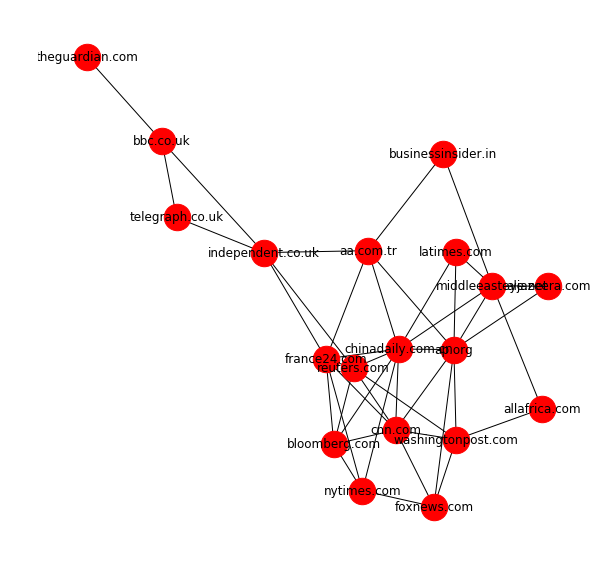

Lambda:  0.11


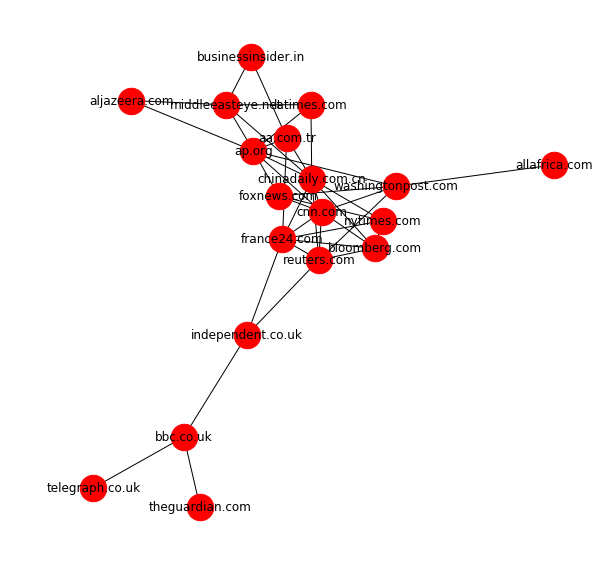

Lambda:  0.12


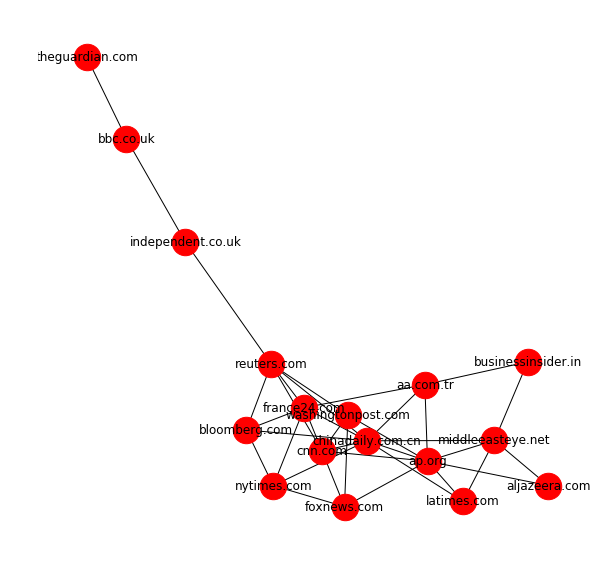

Lambda:  0.13


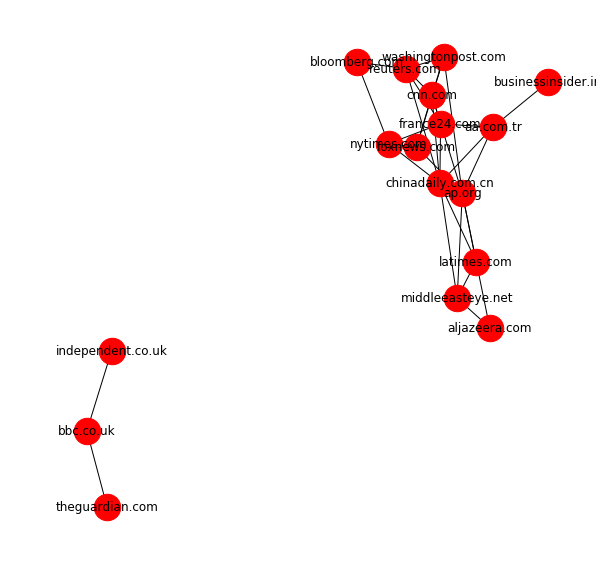

Lambda:  0.14


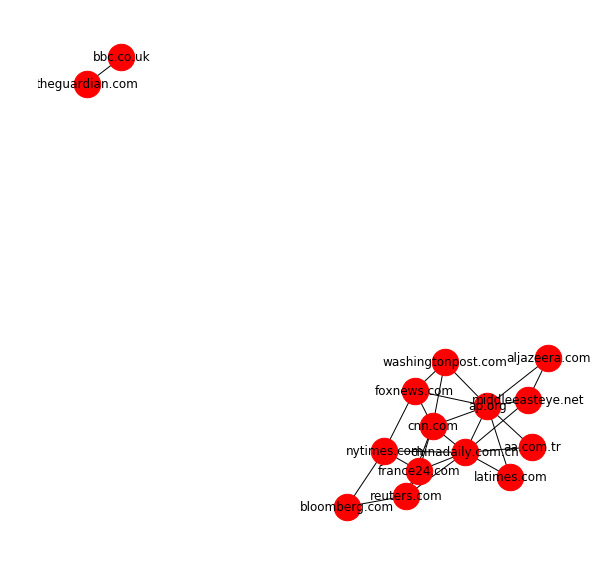

Lambda:  0.15


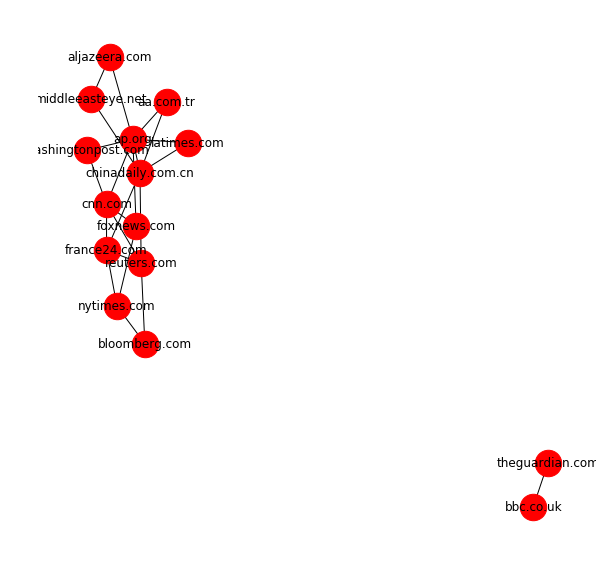

Lambda:  0.16


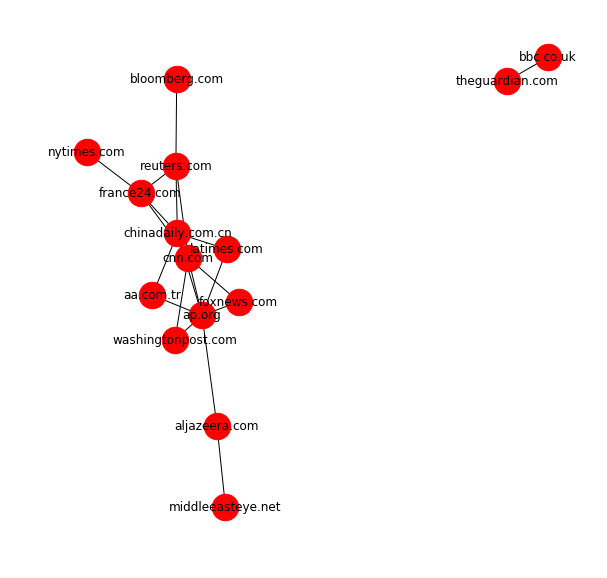

Lambda:  0.17


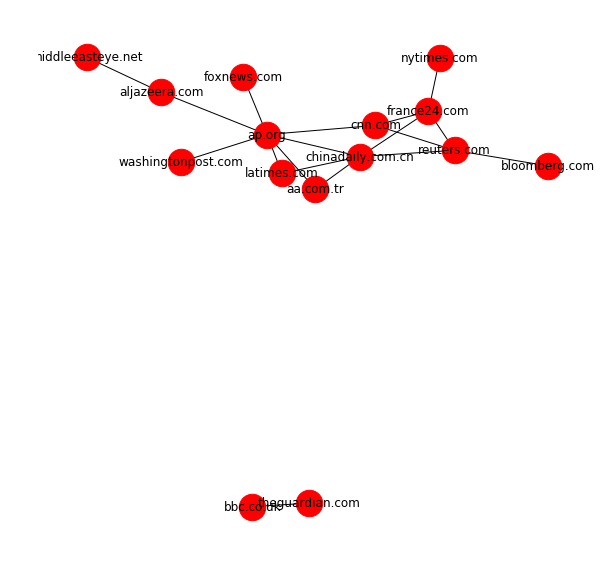

Lambda:  0.18


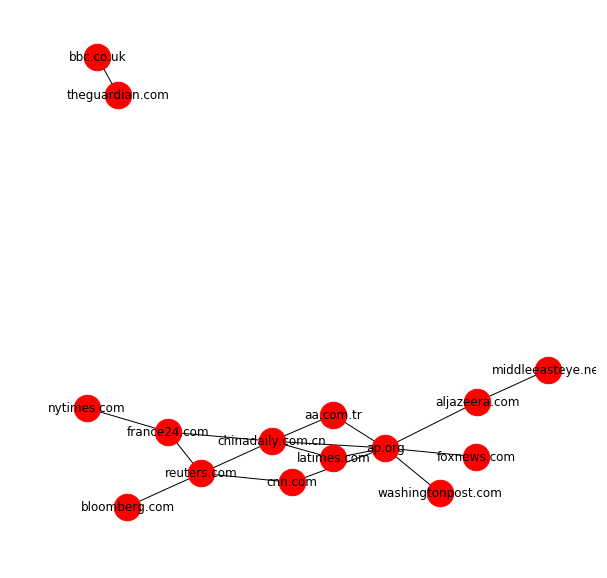

Lambda:  0.19


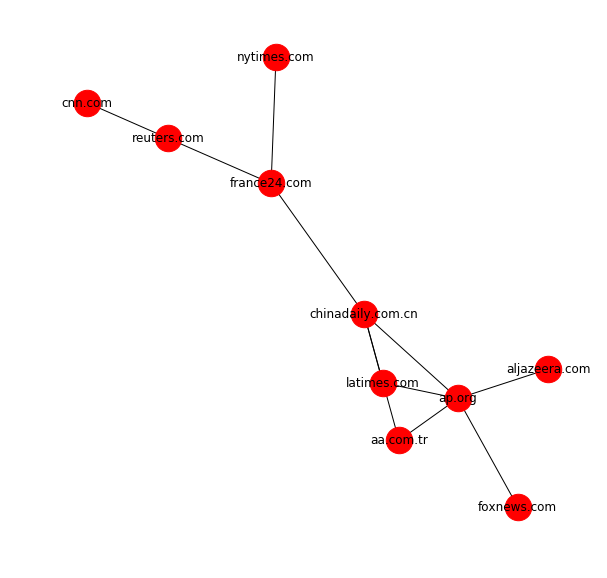

In [20]:
for i in np.arange(0.1, 0.2, 0.01):
    print("Lambda: ", i)
    n_sel = NGraphSelection(Lasso2)
    g = n_sel.fit(A_std, i, 'AND')
    plot_network(g, sources)


## Graph stability

In [21]:
import itertools
import matplotlib.pyplot as plt
import math


%matplotlib inline
A_rand = np.copy(A_std)
np.random.seed(0)
np.random.shuffle(A_rand)


def Slice(matrix, alpha):
    graphs = []
    stab = []
    for i in range(5):
        interval = np.floor(0.2*len(matrix)).astype(int)
        start = i*interval
        stop = (i+1)*interval

        mask = np.ones(len(matrix), dtype=np.bool)
        mask[start:stop] = False
        A_slice = A_rand[mask]
        n_sel = NGraphSelection(Lasso)

        graphs.append(n_sel.fit(A_slice, alpha, 'AND'))

    for g, g_ in itertools.combinations(graphs, 2):
        stab.append(np.sum(np.absolute(g-g_))/2)
    
    return np.float(np.mean(stab))

In [22]:
stability  = []
lambdas = np.arange(0.1, 0.30, 0.01)
for i in lambdas:
    stability.append(Slice(A_rand, i))
    

Text(0.5,1,'Graph stability Brexit')

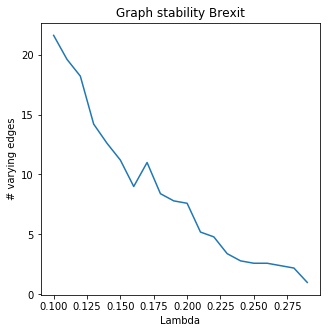

In [25]:
plt.figure(figsize=(5,5))
plt.plot(lambdas, stability)
plt.ylabel("# varying edges")
plt.xlabel("Lambda")
plt.title("Graph stability Brexit")

## Best model

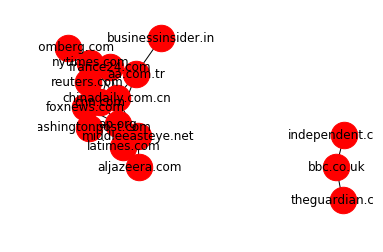

In [26]:
n_sel = NGraphSelection(Lasso2)
g = n_sel.fit(A_std, 0.13, 'AND')
plot_network(g, sources)